# Experimental study of nonclassical teleportation beyond average fidelity

## Ideal case analysis:

Input states:

In [1]:
psix = zeros(2,2,6);

psix(:,:,1) = 1/2*(eye(2) + Pauli(1));
psix(:,:,2) = 1/2*(eye(2) - Pauli(1));
psix(:,:,3) = 1/2*(eye(2) + Pauli(2));
psix(:,:,4) = 1/2*(eye(2) - Pauli(2));
psix(:,:,5) = 1/2*(eye(2) + Pauli(3));
psix(:,:,6) = 1/2*(eye(2) - Pauli(3));

Shared state:

In [30]:
psim = [0 1 -1 0]'/sqrt(2);
psip = [0 1 1 0]'/sqrt(2);

psi11 = [0 0 0 1]';

gamma = 0.9;
rho = gamma*psim*psim' + (1-gamma)*psi11*psi11';

Measurement:

In [20]:
Ma = zeros(4,4,2);
Ma(:,:,1) = psim*psim';
Ma(:,:,2) = eye(4) - Ma(:,:,1);

Generate teleportation data:

In [21]:
sigma = genTeleportationData(rho,Ma,psix);
sigx = squeeze(sigma(:,:,1,:));

In [22]:
paulidecomp = zeros(6,4);

for x = 1:6
    paulidecomp(x,:) = [trace(sigx(:,:,x)) [trace(sigx(:,:,x)*Pauli(1)) trace(sigx(:,:,x)*Pauli(2)) trace(sigx(:,:,x)*Pauli(3))]/trace(sigx(:,:,x))];
    
end

paulidecomp

paulidecomp =
    0.2500    0.9000         0   -0.1000
    0.2500   -0.9000         0   -0.1000
    0.2500         0    0.9000   -0.1000
    0.2500         0   -0.9000   -0.1000
    0.2750         0         0    0.6364
    0.2250         0         0   -1.0000


Witness:

In [31]:
theta = atan(gamma/(1-gamma));

Fax = zeros(2,2,6);
Fax(:,:,1) = -2*sin(theta)*Pauli(1);
Fax(:,:,2) = +2*sin(theta)*Pauli(1);
Fax(:,:,3) = -2*sin(theta)*Pauli(2);
Fax(:,:,4) = +2*sin(theta)*Pauli(2);
Fax(:,:,5) = 2*(1-cos(theta))*(eye(2) - Pauli(3));
Fax(:,:,6) = 2*(1+cos(theta))*(eye(2) + Pauli(3));

Witness value:

In [26]:
beta = 0;
for x = 1:6
    beta = beta + trace(Fax(:,:,x)*sigx(:,:,x));
end

beta

beta =
   -1.6111


Check this value:  
It should be $-2\gamma\sin \theta + 2(1-\gamma)(1-\cos\theta)$

In [32]:
-2*gamma*sin(theta) + 2*(1-gamma)*(1-cos(theta))

ans =
   -1.6111


$M^{VB}_0$ calculation:

In [19]:
M = zeros(4,4);
for x = 1:6
    M = M + Tensor(psix(:,:,x),Fax(:,:,x));
end

[V,D] = eig(M)

V =
         0    1.0000         0         0
   -0.7451         0         0    0.6669
    0.6669         0         0    0.7451
         0         0    1.0000         0
D =
   -0.0000         0         0         0
         0         0         0         0
         0         0         0         0
         0         0         0    8.0000


## Experimental case analysis:

Shared state:

In [83]:
rhoexp = @(v,gamma,delta) 1/4*[(1-v^2)*gamma,0,0,0;0,2-gamma+v^2*(-2+3*gamma),-2*(1-2*delta)^2*v^2*gamma,...
                                0;0,-2*(1-2*delta)^2*v^2*gamma,(1+v^2)*gamma,0;0,0,0,2+v^2*(2-3*gamma)-gamma];

Experimentally obtained values for $\nu$ and $\delta$:

In [84]:
v = 0.962;
delta = 0.872;

Generate teleportation data, fixing a value for $\gamma$:

In [85]:
gamma = 0.9;

sigmaexp = genTeleportationData(rhoexp(v,gamma,delta),Ma,psix);
sigxexp = squeeze(sigmaexp(:,:,1,:));

Fix the teleportation witness, using the optimal value for $\theta$:

In [77]:
theta = atan(2*(1-2*delta)^2*nu^2*gamma/(1+nu^2)/(1-gamma));

Fax = zeros(2,2,6);
Fax(:,:,1) = -2*sin(theta)*Pauli(1);
Fax(:,:,2) = +2*sin(theta)*Pauli(1);
Fax(:,:,3) = -2*sin(theta)*Pauli(2);
Fax(:,:,4) = +2*sin(theta)*Pauli(2);
Fax(:,:,5) = 2*(1-cos(theta))*(eye(2) - Pauli(3));
Fax(:,:,6) = 2*(1+cos(theta))*(eye(2) + Pauli(3));

Witness value:

In [81]:
beta = 0;
for x = 1:6
    beta = beta + trace(Fax(:,:,x)*sigxexp(:,:,x));
end

beta

beta =
   -0.6823


Check that this is equal to $1+v^2-2\gamma v^2-(1-\gamma)(1+v^2)\cos(\theta) - 2\gamma(1-2\delta)^2v^2\sin(\theta)$

In [80]:
1+v^2-2*gamma*v^2-(1-gamma)*(1+v^2)*cos(theta) - 2*gamma*(1-2*delta)^2*v^2*sin(theta)

ans =
   -0.6823


### Teleportation based estimation of entanglement based on witness violation

In [109]:
%%file teleportationNegativityWitness.m

function TNW = teleportationNegativityWitness(Fax,betaobs,omegax)

[dB,~,oa,ma] = size(Fax); % dim. of B, no. of outcomes of Ma, number of 
                            % input states for Alice
[dV,~,~] = size(omegax); % dimension of input states

cvx_begin sdp quiet

    variable Map(dV*dB,dV*dB,oa) hermitian semidefinite% M_a^VB
    variable Mam(dV*dB,dV*dB,oa) hermitian semidefinite % N_a^VB
    variable rhoBp(dB,dB) hermitian semidefinite
    variable rhoBm(dB,dB) hermitian semidefinite
    
    expression betavar
    
    minimise trace(rhoBm) 
    
    subject to
    
    
    betavar = 0;
    for x = 1:ma
        for a = 1:oa
            betavar = betavar + trace((Map(:,:,a)-Mam(:,:,a))*...
                Tensor(omegax(:,:,x),Fax(:,:,a,x)));
        end
    end
    
    betavar == betaobs
    
    sum(Map,3) == Tensor(eye(dV),rhoBp)
    sum(Mam,3) == Tensor(eye(dV),rhoBm)
    % sum_a Ma+/- = Id otimes rhoB (no-signalling)
    
cvx_end

TNW = cvx_optval;

end


Created file '/home/phyps/Dropbox/Shared Folders/Steering and teleportation/experimentalists/teleportationNegativityWitness.m'.


### Ideal case

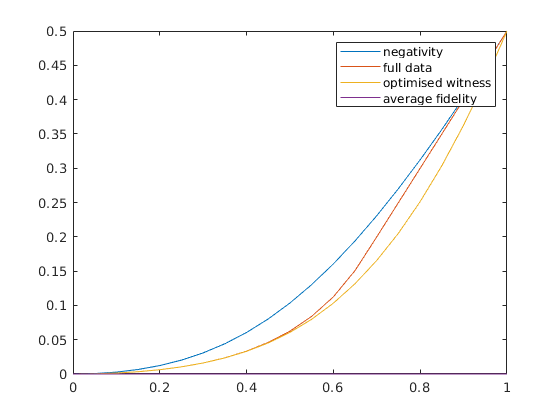

In [153]:
clear

omegax = zeros(2,2,6);

omegax(:,:,1) = 1/2*(eye(2) + Pauli(1));
omegax(:,:,2) = 1/2*(eye(2) - Pauli(1));
omegax(:,:,3) = 1/2*(eye(2) + Pauli(2));
omegax(:,:,4) = 1/2*(eye(2) - Pauli(2));
omegax(:,:,5) = 1/2*(eye(2) + Pauli(3));
omegax(:,:,6) = 1/2*(eye(2) - Pauli(3));

Gax = zeros(2,2,2,6);
Gax(:,:,1,1) = 1/6*(eye(2) + Pauli(1))/2;
Gax(:,:,1,2) = 1/6*(eye(2) - Pauli(1))/2;
Gax(:,:,1,3) = 1/6*(eye(2) + Pauli(2))/2;
Gax(:,:,1,4) = 1/6*(eye(2) - Pauli(2))/2;
Gax(:,:,1,5) = 1/6*(eye(2) + Pauli(3))/2;
Gax(:,:,1,6) = 1/6*(eye(2) - Pauli(3))/2;


psim = [0 1 -1 0]'/sqrt(2);
psip = [0 1 1 0]'/sqrt(2);

psi11 = [0 0 0 1]';

Ma = zeros(4,4,2);
Ma(:,:,1) = psim*psim';
Ma(:,:,2) = eye(4) - Ma(:,:,1);

npoints = 21;
gammav = linspace(0,1,npoints);
TNWv = zeros(1,npoints);
TNWAFv = zeros(1,npoints);
TNv = zeros(1,npoints);
Nv = zeros(1,npoints);

for i = 1:npoints

    gamma = gammav(i);
    rho = gamma*psim*psim' + (1-gamma)*psi11*psi11';
    Nv(i) = Negativity(rho);

    sigma = genTeleportationData(rho,Ma,omegax);

    theta = atan(gamma/(1-gamma));

    Fax = zeros(2,2,2,6);
    Fax(:,:,1,1) = -2*sin(theta)*Pauli(1);
    Fax(:,:,1,2) = +2*sin(theta)*Pauli(1);
    Fax(:,:,1,3) = -2*sin(theta)*Pauli(2);
    Fax(:,:,1,4) = +2*sin(theta)*Pauli(2);
    Fax(:,:,1,5) = 2*(1-cos(theta))*(eye(2) - Pauli(3));
    Fax(:,:,1,6) = 2*(1+cos(theta))*(eye(2) + Pauli(3));

    betaobs = 0;
    for x = 1:6
        for a = 1:2
            betaobs = betaobs + trace(Fax(:,:,a,x)*sigma(:,:,a,x));
        end
    end
    
    betaobsAF = 0;
    for x = 1:6
        for a = 1:2
            betaobsAF = betaobsAF + trace(Gax(:,:,a,x)*sigma(:,:,a,x));
        end
    end
    
    TNWv(i) = teleportationNegativityWitness(Fax,betaobs,omegax);
    TNWAFv(i) = teleportationNegativityWitness(Gax,betaobsAF,omegax);
    TNv(i) = teleportationNegativity(sigma,omegax);
    
end

plot(gammav,Nv,gammav,TNv,gammav,TNWv,gammav,TNWAFv)
legend('negativity','full data','optimised witness','average fidelity')